In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from pathlib import Path
from statsmodels.graphics.tsaplots import plot_acf

# Set plot styling
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [11]:
tickers = [
    'AAL'	
    ,'ALGT'
    ,'ALK'	
    ,'DAL'	
    ,'ITA'	
    ,'IYT'	
    ,'JBLU'	
    ,'JETS'	
    ,'LUV'	
    ,'UAL'
    ,'Oil'
]

In [3]:
# Load the stock price data
data_path = Path("../../Data/Processed/merged_data_202506131413.pkl")
with open(data_path, 'rb') as f:
    stock_data = pickle.load(f)

In [5]:
# Display basic information about the dataset
print(f"Date range: {stock_data.index.min()} to {stock_data.index.max()}")

# Check for missing values
na_counts = stock_data.isna().sum()
print(f"\nMissing values per stock:")
print(na_counts[na_counts > 0] if na_counts.sum() > 0 else "No missing values")

Date range: 2018-01-02 09:30:00 to 2025-05-30 15:45:00

Missing values per stock:
No missing values


## Correlation Analysis

Now we'll compute and visualize the correlation matrix between stock returns. The correlation coefficient ranges from -1 to 1:

- +1 indicates perfect positive correlation (stocks move exactly together)
- 0 indicates no correlation (stocks move independently)
- -1 indicates perfect negative correlation (stocks move exactly opposite)

In [7]:
# New dataframe which is all columns with '%Chg' suffix
returns = stock_data.filter(like='Change')

# Rename the columns to remove the '%Chg' suffix
returns.columns = returns.columns.str.replace('_Change', '', regex=False)

# Compute correlation matrix of daily returns
correlation_matrix = returns.corr()

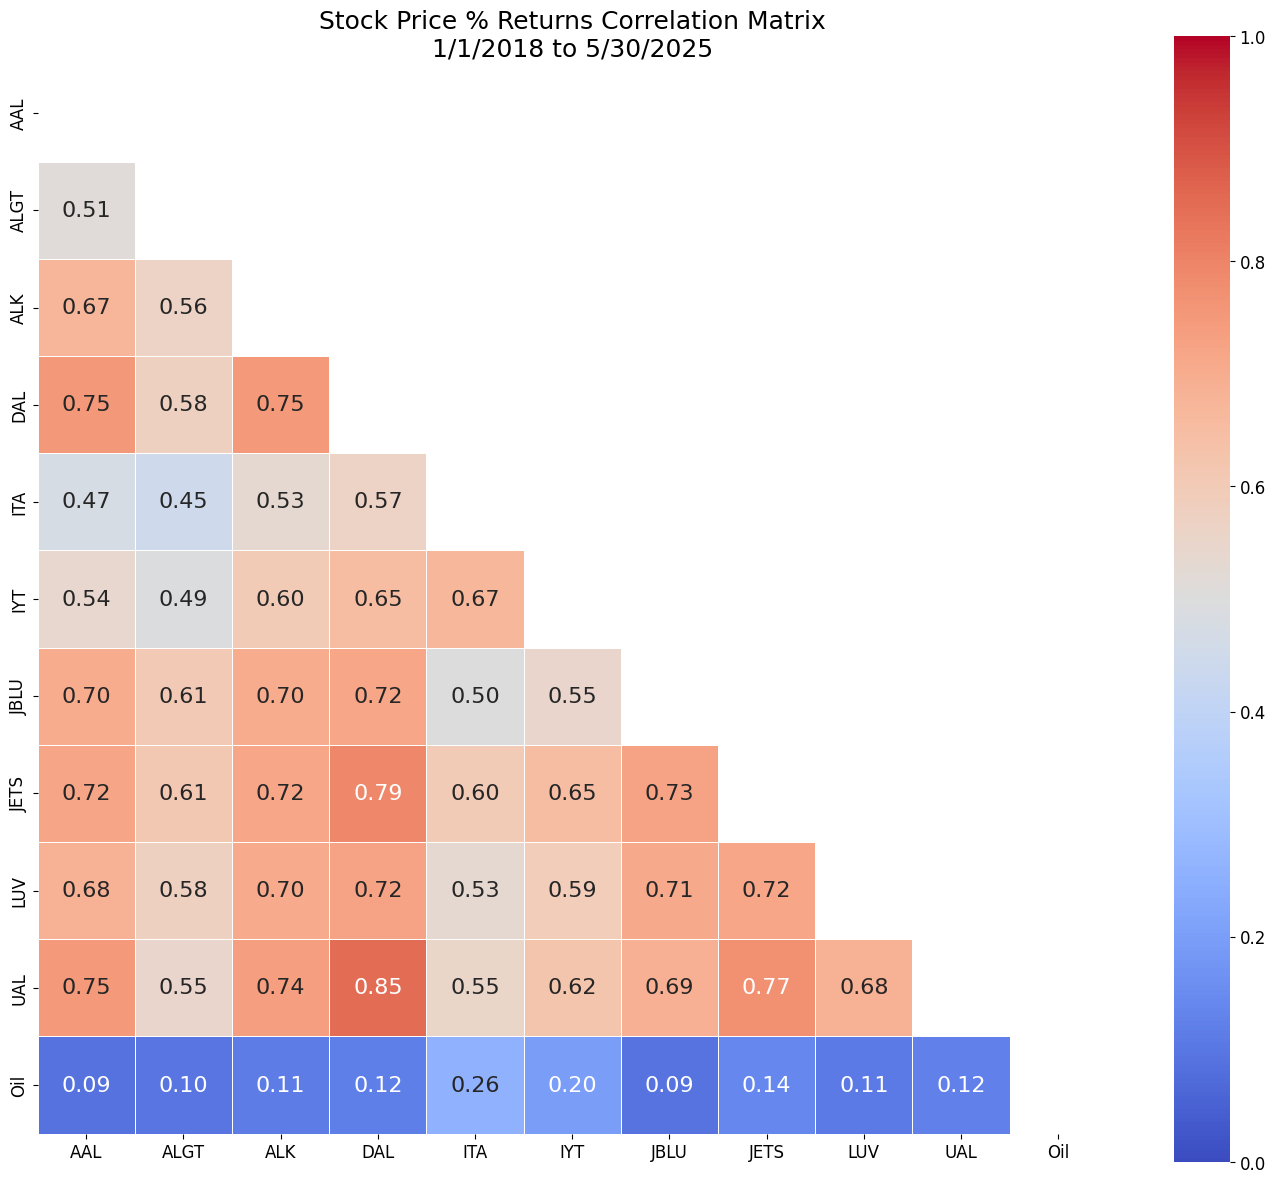

In [8]:
# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(14, 12))

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Create heatmap with annotations (lower triangle only)
sns.heatmap(
    correlation_matrix, 
    mask=mask,
    annot=True, 
    cmap='coolwarm', 
    vmin=0, 
    vmax=1, 
    fmt='.2f',
    linewidths=0.5,
    square=True,
    annot_kws={'size': 16}
)

plt.title('Stock Price % Returns Correlation Matrix\n1/1/2018 to 5/30/2025', fontsize=18)
plt.tight_layout()
plt.show()

<Figure size 1400x800 with 0 Axes>

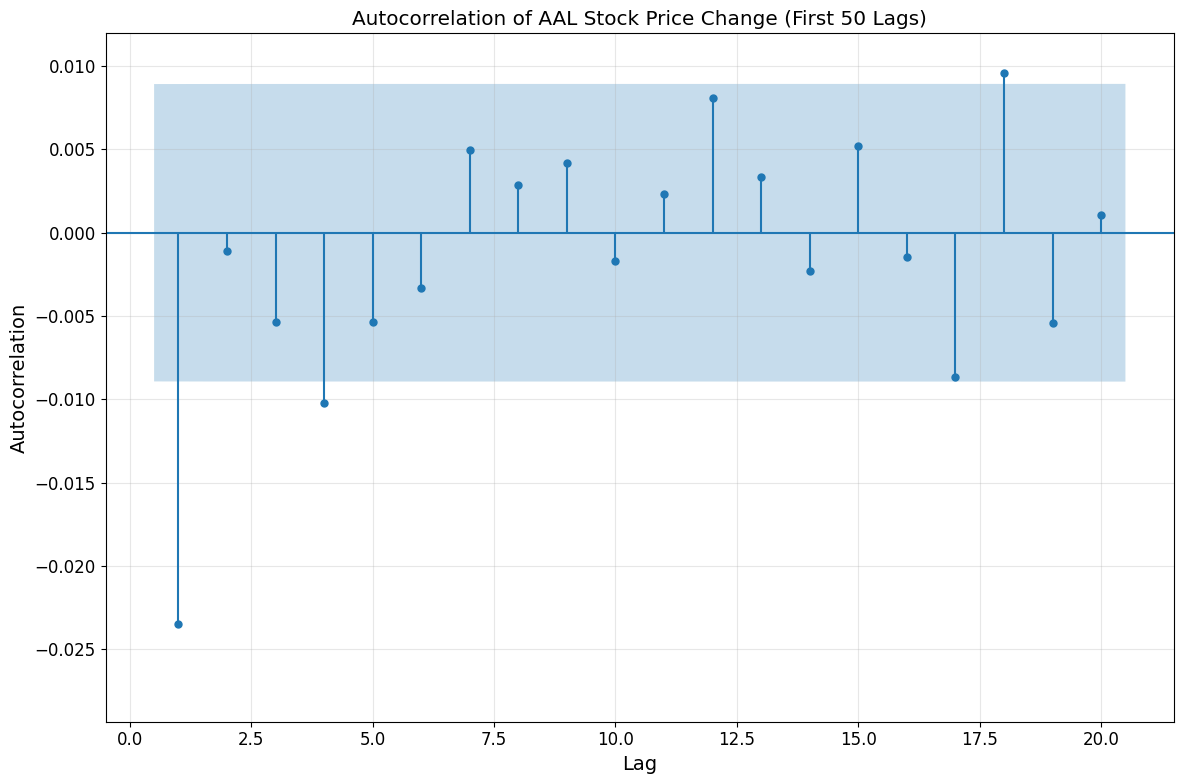

In [9]:
# Plot autocorrelation for AAL stock for the first 50 lags
plt.figure(figsize=(14, 8))

# Create a clean autocorrelation plot without confidence intervals
plot_acf(returns['AAL'].dropna(), 
         lags=20, 
         alpha=0.05, 
         title=f'Autocorrelation of AAL Stock Price Change (First 50 Lags)',
         zero=False,
         auto_ylims=True)

# Enhance plot appearance
plt.xlabel('Lag', fontsize=14)
plt.ylabel('Autocorrelation', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

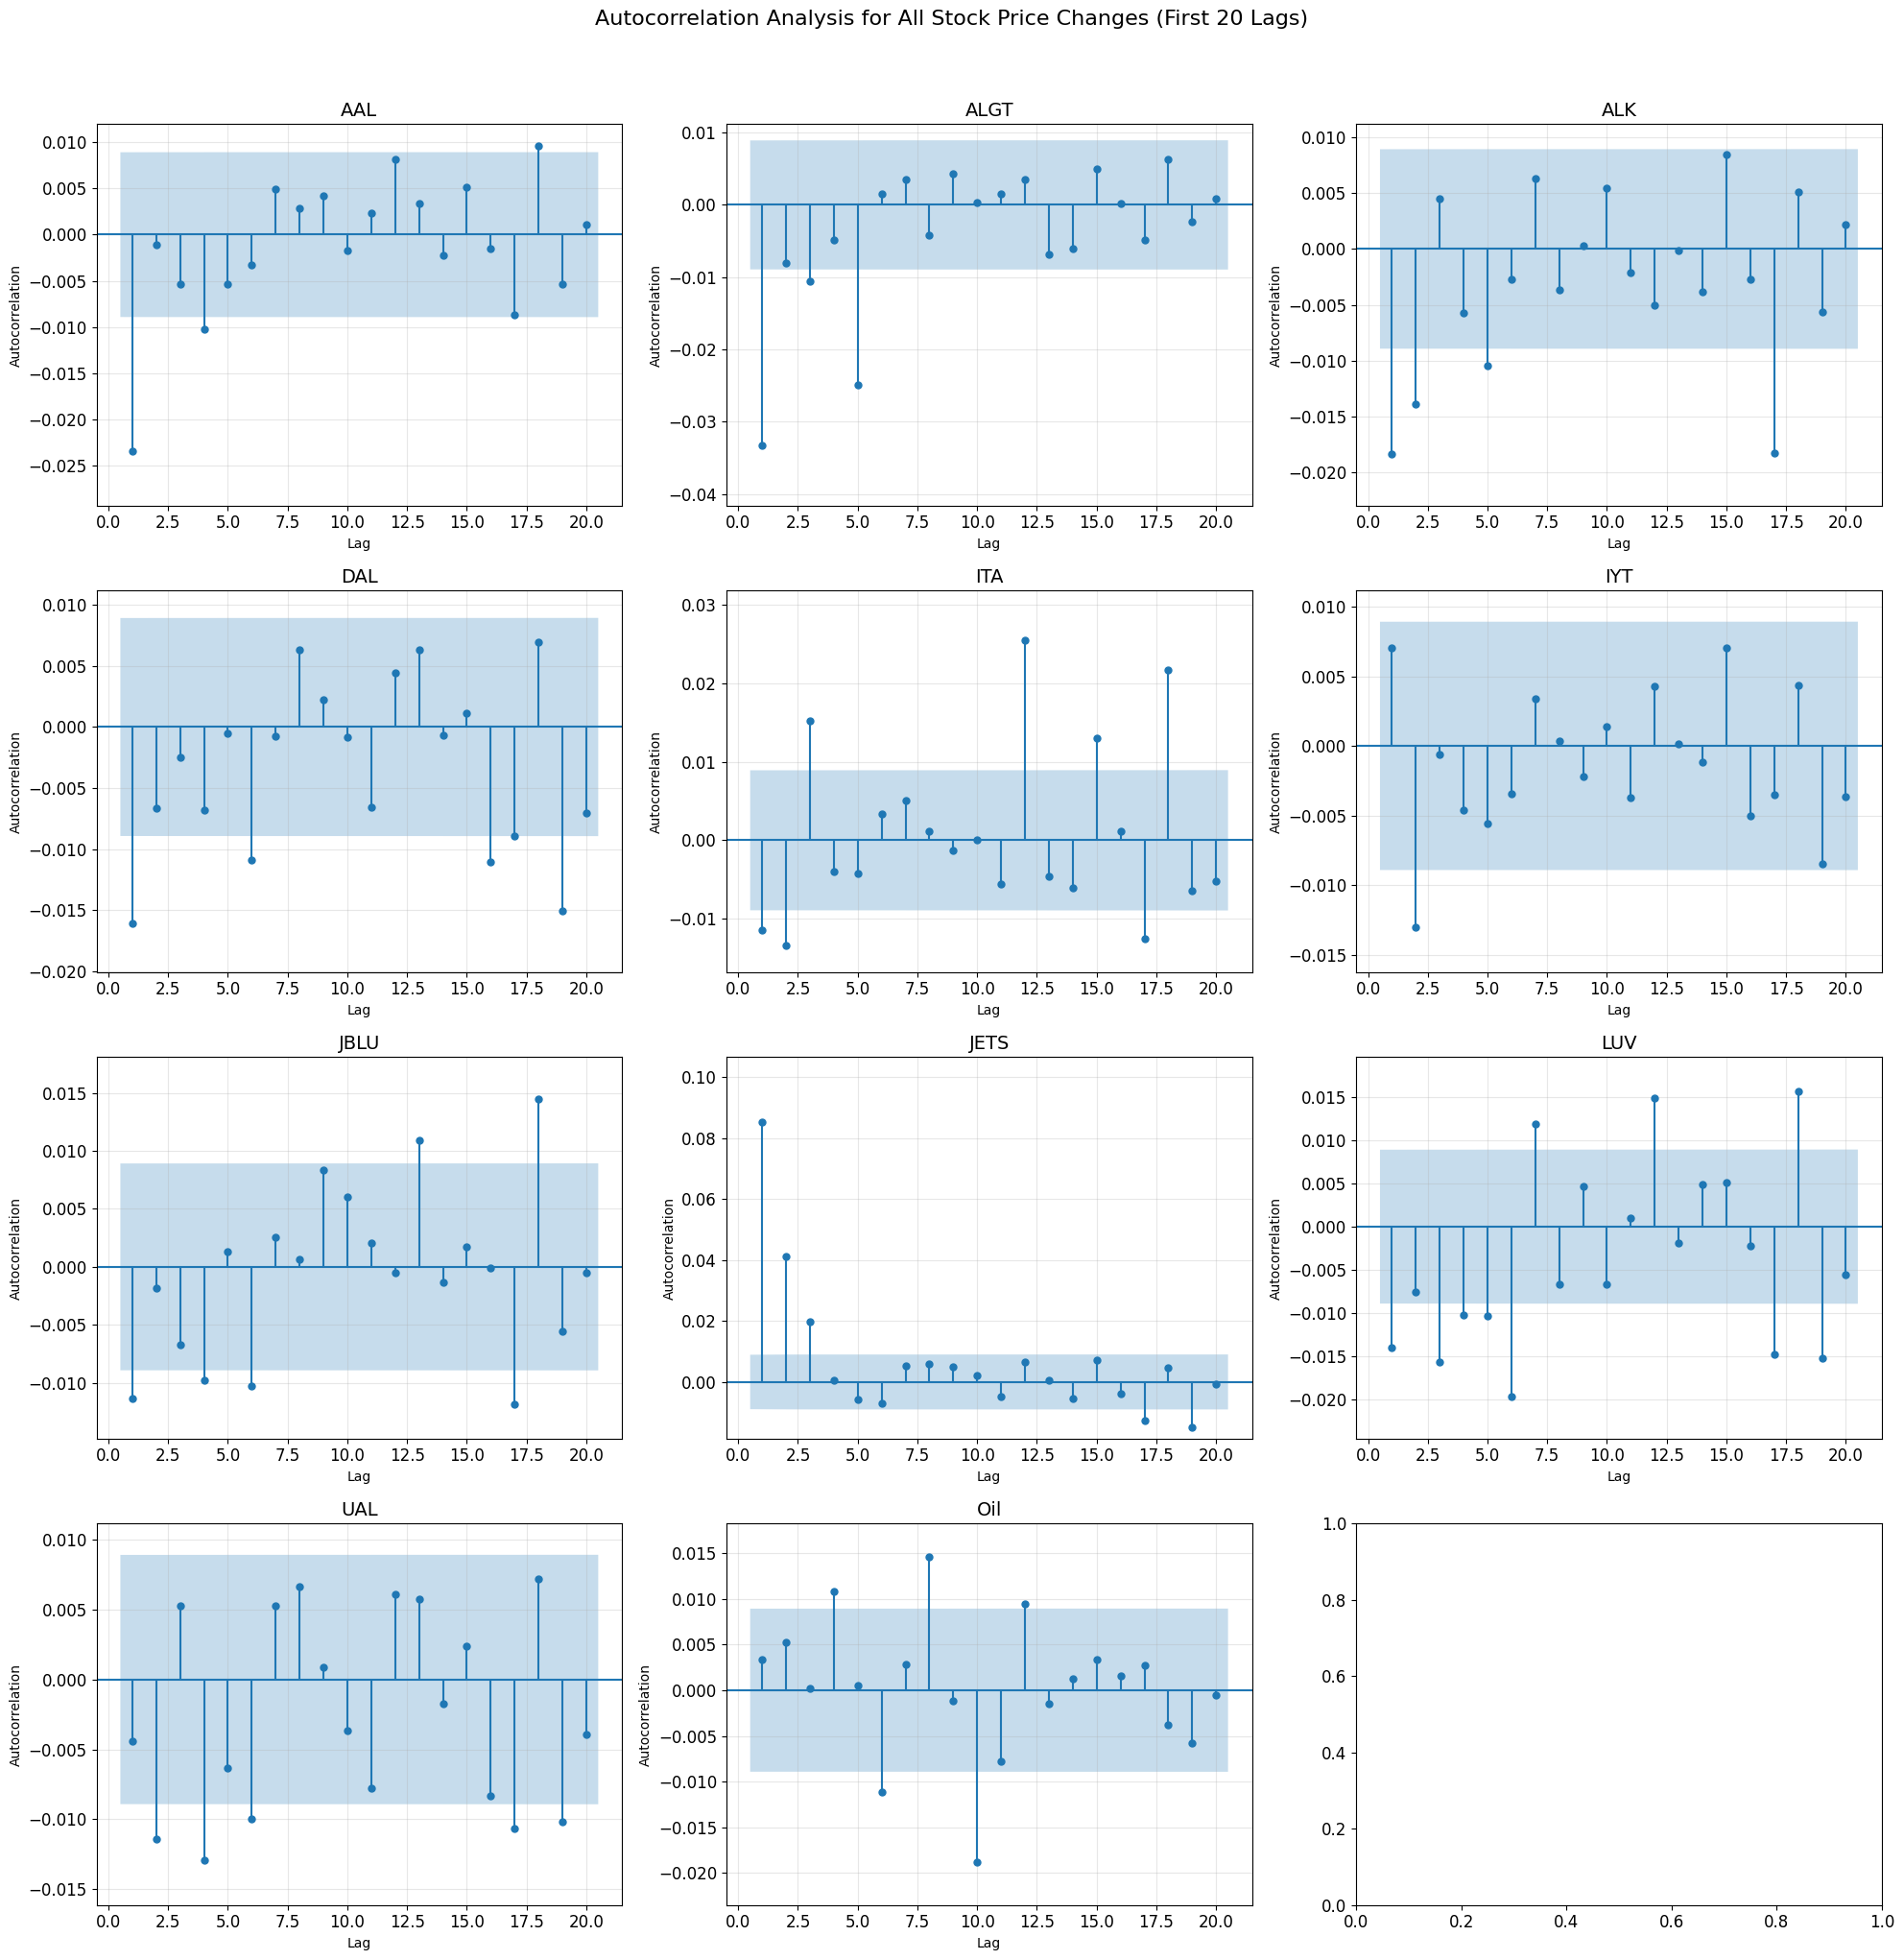

In [15]:
# Create a matrix of autocorrelation plots for all tickers
fig, axes = plt.subplots(4, 3, figsize=(20, 20))
axes = axes.flatten()

for i, ticker in enumerate(tickers):
    # Plot autocorrelation for each ticker
    plot_acf(returns[ticker].dropna(), 
             lags=20, 
             alpha=0.05, 
             title=f'{ticker} Autocorrelation',
             zero=False,
             auto_ylims=True,
             ax=axes[i])
    
    # Customize each subplot
    axes[i].set_xlabel('Lag', fontsize=10)
    axes[i].set_ylabel('Autocorrelation', fontsize=10)
    axes[i].grid(True, alpha=0.3)
    axes[i].set_title(f'{ticker}', fontsize=14)

plt.suptitle('Autocorrelation Analysis for All Stock Price Changes (First 20 Lags)', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## Intraday Seasonality Analysis

Stock returns often exhibit intraday patterns or 'seasonality' where certain times of the day consistently show different behavior. For example, market open and close often have higher volatility.

Below, we'll analyze the intraday seasonality pattern for AAL stock by:

1. Extracting the time of day from the datetime index
2. Grouping returns by time of day
3. Calculating statistics (mean and interquartile range) for each time period
4. Visualizing the patterns to identify any recurring intraday trends

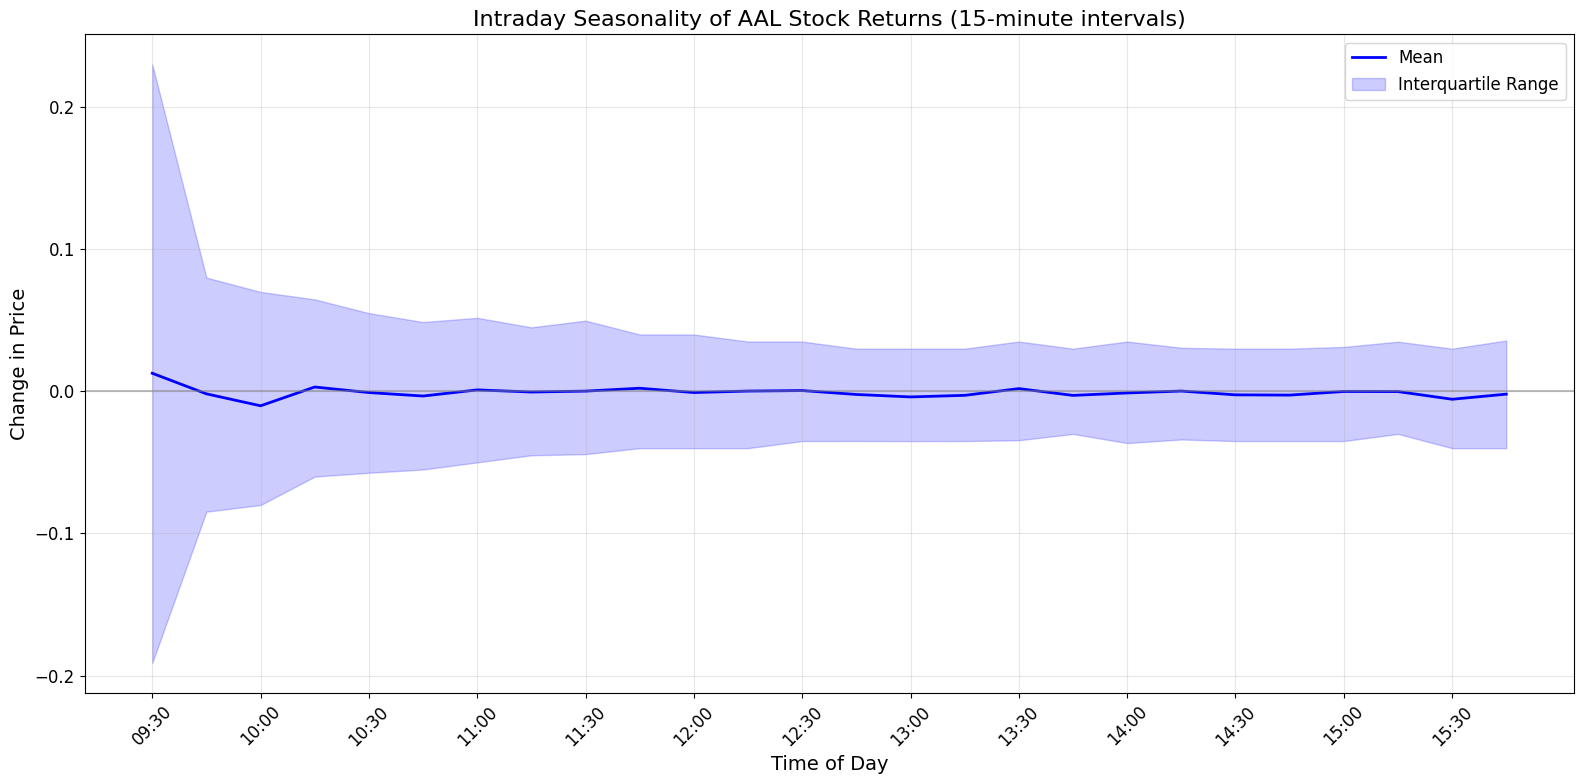

In [18]:
# Create a dataframe with AAL returns
aal_returns = pd.DataFrame({
    'returns': stock_data.filter(like='AAL_Change').iloc[:, 0]
})

# Extract time of day from the index
aal_returns['time_of_day'] = aal_returns.index.strftime('%H:%M')

# Group by time of day and calculate statistics
time_stats = aal_returns.groupby('time_of_day')['returns'].agg([
    ('mean', 'mean'),
    ('median', 'median'),
    ('q25', lambda x: x.quantile(0.25)),
    ('q75', lambda x: x.quantile(0.75))
]).reset_index()

# Sort by time of day
time_stats['time_obj'] = pd.to_datetime(time_stats['time_of_day'], format='%H:%M').dt.time
time_stats = time_stats.sort_values('time_obj')

# Create the seasonality plot
plt.figure(figsize=(16, 8))

# Plot the mean
plt.plot(time_stats['time_of_day'], time_stats['mean'], 'b-', linewidth=2, label='Mean')

# Plot the interquartile range as a shaded area
plt.fill_between(
    time_stats['time_of_day'], 
    time_stats['q25'], 
    time_stats['q75'], 
    color='blue', 
    alpha=0.2, 
    label='Interquartile Range'
)

# Add a horizontal line at y=0
plt.axhline(y=0, color='gray', linestyle='-', alpha=0.5)

# Format the plot
plt.title('Intraday Seasonality of AAL Stock Returns (15-minute intervals)', fontsize=16)
plt.xlabel('Time of Day', fontsize=14)
plt.ylabel('Change in Price', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.legend()

# Only show every other x-tick to avoid crowding
plt.xticks(time_stats['time_of_day'][::2])
plt.tight_layout()
plt.show()

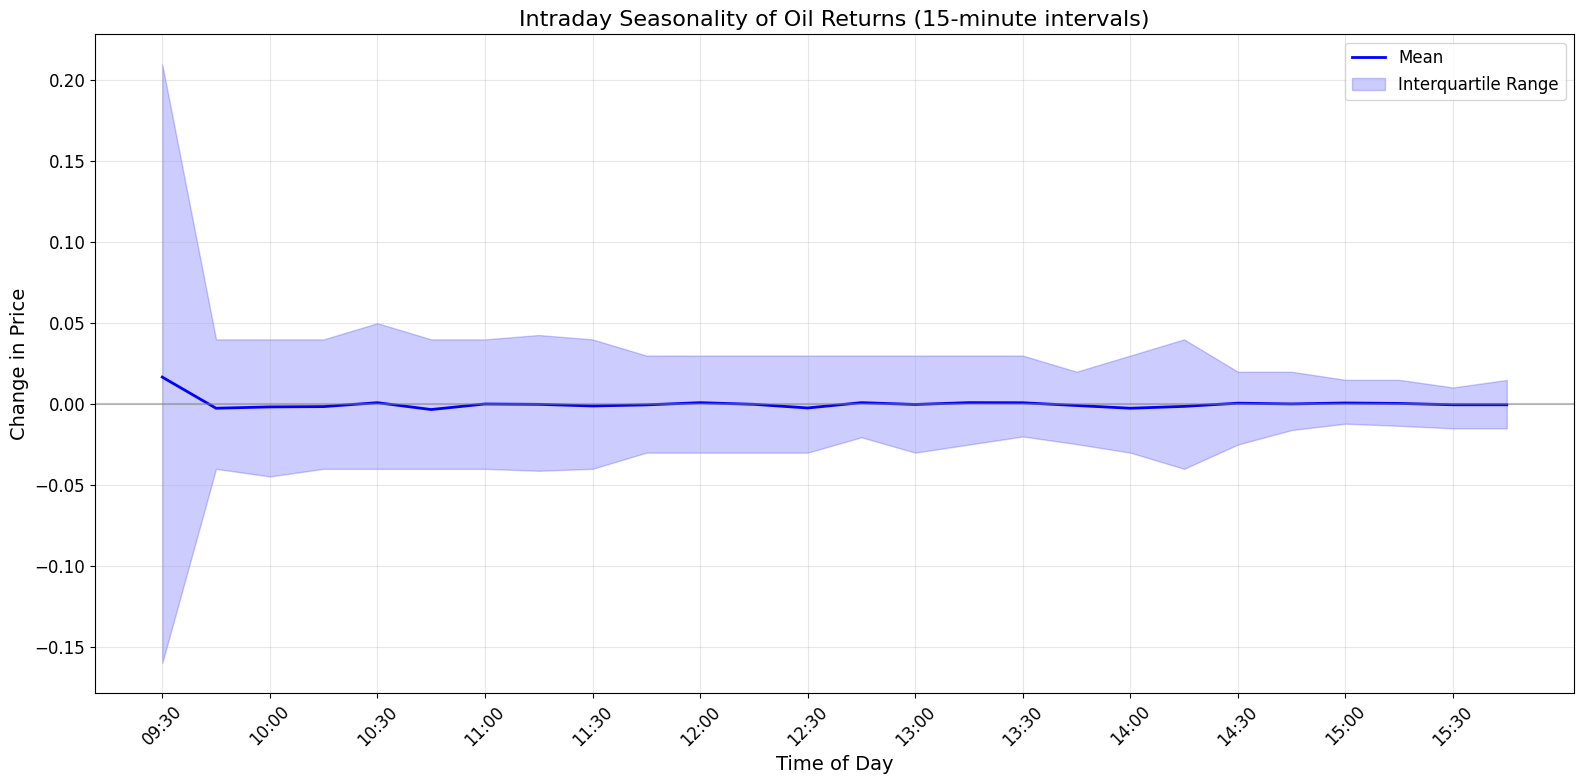

In [19]:
# Create a dataframe with AAL returns
aal_returns = pd.DataFrame({
    'returns': stock_data.filter(like='Oil_Change').iloc[:, 0]
})

# Extract time of day from the index
aal_returns['time_of_day'] = aal_returns.index.strftime('%H:%M')

# Group by time of day and calculate statistics
time_stats = aal_returns.groupby('time_of_day')['returns'].agg([
    ('mean', 'mean'),
    ('median', 'median'),
    ('q25', lambda x: x.quantile(0.25)),
    ('q75', lambda x: x.quantile(0.75))
]).reset_index()

# Sort by time of day
time_stats['time_obj'] = pd.to_datetime(time_stats['time_of_day'], format='%H:%M').dt.time
time_stats = time_stats.sort_values('time_obj')

# Create the seasonality plot
plt.figure(figsize=(16, 8))

# Plot the mean
plt.plot(time_stats['time_of_day'], time_stats['mean'], 'b-', linewidth=2, label='Mean')

# Plot the interquartile range as a shaded area
plt.fill_between(
    time_stats['time_of_day'], 
    time_stats['q25'], 
    time_stats['q75'], 
    color='blue', 
    alpha=0.2, 
    label='Interquartile Range'
)

# Add a horizontal line at y=0
plt.axhline(y=0, color='gray', linestyle='-', alpha=0.5)

# Format the plot
plt.title('Intraday Seasonality of Oil Returns (15-minute intervals)', fontsize=16)
plt.xlabel('Time of Day', fontsize=14)
plt.ylabel('Change in Price', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.legend()

# Only show every other x-tick to avoid crowding
plt.xticks(time_stats['time_of_day'][::2])
plt.tight_layout()
plt.show()